In [55]:
import pandas as pd

In [56]:
user_paths = pd.read_csv("data/processed/user_paths.csv")

In [57]:
print("\nColumns:", user_paths.columns.tolist())
print(user_paths.head())


Columns: ['User ID', 'Path', 'Path_Conversion', 'path_length', 'n_unique_channels', 'first_channel', 'last_channel', 'path_start', 'path_end', 'path_duration']
   User ID                                   Path  Path_Conversion  \
0    10028                             Search Ads                1   
1    10045               Search Ads > Display Ads                1   
2    10062  Social Media > Direct Traffic > Email                1   
3    10068                             Search Ads                1   
4    10095                            Display Ads                1   

   path_length  n_unique_channels first_channel last_channel  \
0            1                  1    Search Ads   Search Ads   
1            2                  2    Search Ads  Display Ads   
2            3                  3  Social Media        Email   
3            1                  1    Search Ads   Search Ads   
4            1                  1   Display Ads  Display Ads   

                  path_start     

In [58]:
required = {"User ID", "Path", "Path_Conversion", "first_channel", "last_channel"}
missing = required - set(user_paths.columns)
if missing:
    print("\n Missing expected columns:", missing)
else:
    print("\nSchema looks good (all required columns present).")



Schema looks good (all required columns present).


In [59]:
if "Campaign" not in user_paths.columns:
    print("\n No 'Campaign' column in user_paths. You may need to merge campaign info back from raw events.")
else:
    n_campaigns = user_paths["Campaign"].nunique()
    users_per_campaign = user_paths.groupby("Campaign")["User ID"].nunique().sort_values(ascending=False)
    
    print(f"\n# of unique campaigns: {n_campaigns}")
    print("Top 5 campaigns by users exposed:")
    print(users_per_campaign.head())


 No 'Campaign' column in user_paths. You may need to merge campaign info back from raw events.


In [60]:
events = pd.read_parquet("data/processed/events_clean.parquet")  # or CSV
print("Events shape:", events.shape)
print(events.head())

Events shape: (10000, 5)
  User ID                 Timestamp         Channel            Campaign  \
0   83281 2025-02-10 07:58:51+00:00           Email  New Product Launch   
1   68071 2025-02-10 23:38:48+00:00      Search Ads         Winter Sale   
2   90131 2025-02-11 10:41:07+00:00    Social Media     Brand Awareness   
3   71026 2025-02-10 08:19:44+00:00  Direct Traffic                   -   
4   94486 2025-02-10 15:15:46+00:00           Email         Retargeting   

   conversion_flag  
0                0  
1                0  
2                1  
3                1  
4                1  


In [61]:
user_campaigns = (
    events.groupby("User ID")["Campaign"]
          .unique()
          .reset_index()
          .rename(columns={"Campaign": "campaign_list"})
)

print("User-campaign mapping (head):")
print(user_campaigns.head())


User-campaign mapping (head):
  User ID                                      campaign_list
0   10028  ['-', 'Discount Offer']
Categories (6, object)...
1   10045  ['New Product Launch', 'Discount Offer']
Categ...
2   10062  ['Brand Awareness', '-']
Categories (6, object...
3   10068  ['Winter Sale', '-', 'New Product Launch', 'Re...
4   10095  ['Retargeting', '-', 'New Product Launch']
Cat...


In [62]:
first_campaign = (
    events.groupby("User ID")["Campaign"]
          .first()
          .reset_index()
          .rename(columns={"Campaign": "Campaign"})
)


user_paths["User ID"] = user_paths["User ID"].astype(str)
first_campaign["User ID"] = first_campaign["User ID"].astype(str)

user_paths = user_paths.merge(first_campaign, on="User ID", how="left")

In [63]:
if "Campaign" in user_paths.columns:
    print("# unique campaigns:", user_paths["Campaign"].nunique())
    print("Top 5 campaigns by user exposure:")
    print(user_paths["Campaign"].value_counts().head())

elif "campaign_list" in user_paths.columns:
    all_camps = pd.Series([c for lst in user_paths["campaign_list"].dropna() for c in lst])
    print("# unique campaigns:", all_camps.nunique())
    print("Top 5 campaigns overall:")
    print(all_camps.value_counts().head())

# unique campaigns: 6
Top 5 campaigns by user exposure:
Campaign
-                     930
New Product Launch    402
Brand Awareness       397
Discount Offer        386
Retargeting           367
Name: count, dtype: int64


In [64]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [65]:
user_paths = pd.read_csv("data/processed/user_paths.csv")           # has 'User ID', 'Path_Conversion'
try:
    events = pd.read_parquet("data/processed/events_clean.parquet") # has 'User ID', 'Campaign'
except FileNotFoundError:
    events = pd.read_csv("data/processed/events_clean.csv")

In [66]:
user_paths["User ID"] = user_paths["User ID"].astype(str).str.strip()
events["User ID"]     = events["User ID"].astype(str).str.strip()


In [67]:
events["Campaign"] = events["Campaign"].astype(str).str.strip()
events.loc[events["Campaign"].isin(["", "nan", "None", "NaN", "-"]), "Campaign"] = np.nan


In [68]:
events = events.dropna(subset=["User ID", "Campaign"])
user_paths = user_paths.dropna(subset=["User ID"])
events = events[events["User ID"].isin(user_paths["User ID"])]


In [69]:
overlap_users = len(set(events["User ID"]).intersection(set(user_paths["User ID"])))
print(f"Users in events: {events['User ID'].nunique()} | in user_paths: {user_paths['User ID'].nunique()} | overlap: {overlap_users}")


Users in events: 2666 | in user_paths: 2847 | overlap: 2666


In [70]:
user_conv = (user_paths
             .drop_duplicates(subset=["User ID"])
             .set_index("User ID")["Path_Conversion"])

camp_users = (events.groupby("Campaign")["User ID"]
                     .unique()
                     .reset_index(name="exposed_users"))

all_users = set(user_conv.index)


 Saved campaign incrementality to data/processed/campaign_incrementality.csv
             Campaign  Conv_Exposed  Conv_Control  Lift%  p_value  n_exposed  \
0     Brand Awareness      0.890399      0.802065  11.01      0.0       1104   
1         Retargeting      0.888686      0.803541  10.60      0.0       1096   
2         Winter Sale      0.888479      0.804200  10.48      0.0       1085   
3      Discount Offer      0.885687      0.807863   9.63      0.0       1041   
4  New Product Launch      0.881356      0.807068   9.20      0.0       1121   

   n_control  
0       1743  
1       1751  
2       1762  
3       1806  
4       1726  


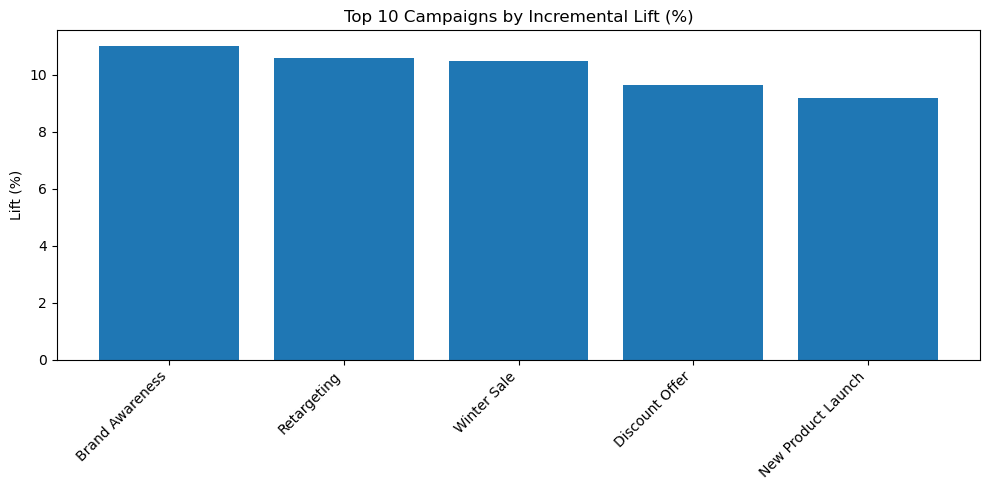

In [71]:
rows = []
for _, r in camp_users.iterrows():
    camp = r["Campaign"]
    exposed = set(r["exposed_users"]).intersection(all_users)  # only users with conversion labels
    control = all_users - exposed

    n_exp, n_ctl = len(exposed), len(control)

    if n_exp == 0 or n_ctl == 0:
        rows.append({"Campaign": camp, "Conv_Exposed": np.nan, "Conv_Control": np.nan,
                     "Lift%": np.nan, "p_value": np.nan, "n_exposed": n_exp, "n_control": n_ctl})
        continue

    exp_conv = user_conv.loc[list(exposed)]
    ctl_conv = user_conv.loc[list(control)]

    conv_exp = exp_conv.mean()
    conv_ctl = ctl_conv.mean()
    lift = (conv_exp - conv_ctl) / conv_ctl if conv_ctl > 0 else np.inf

    # two-proportion z-test (pooled)
    x1, n1 = int(exp_conv.sum()), len(exp_conv)
    x2, n2 = int(ctl_conv.sum()), len(ctl_conv)
    p_pool = (x1 + x2) / (n1 + n2)
    denom = np.sqrt(max(p_pool * (1 - p_pool), 1e-12) * (1/n1 + 1/n2))
    z = (conv_exp - conv_ctl) / denom if denom > 0 else np.nan

    from math import erf, sqrt
    phi = lambda z_: 0.5 * (1 + erf(z_ / sqrt(2)))
    p_value = 2 * (1 - phi(abs(z))) if not np.isnan(z) else np.nan

    rows.append({
        "Campaign": camp,
        "Conv_Exposed": round(float(conv_exp), 6),
        "Conv_Control": round(float(conv_ctl), 6),
        "Lift%": round(float(lift) * 100, 2) if np.isfinite(lift) else np.inf,
        "p_value": round(float(p_value), 6) if p_value == p_value else np.nan,
        "n_exposed": n1,
        "n_control": n2
    })

results = (pd.DataFrame(rows)
           .sort_values(["Lift%"], ascending=False)
           .reset_index(drop=True))

Path("data/processed").mkdir(parents=True, exist_ok=True)
out_path = "data/processed/campaign_incrementality.csv"
results.to_csv(out_path, index=False)
print(f" Saved campaign incrementality to {out_path}")
print(results.head(10))


plot_df = results.replace([np.inf, -np.inf], np.nan).dropna(subset=["Lift%"]).head(10)
plt.figure(figsize=(10,5))
plt.bar(plot_df["Campaign"].astype(str), plot_df["Lift%"])
plt.title("Top 10 Campaigns by Incremental Lift (%)")
plt.ylabel("Lift (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import statsmodels.api as sm
import numpy as np 

target_channel = "Email"

user_paths["treated"] = user_paths["User ID"].isin(
    events[events["Channel"] == target_channel]["User ID"]
)

X = user_paths[["path_length", "n_unique_channels"]]
y = user_paths["treated"].astype(int)

logit = LogisticRegression(max_iter=1000)
logit.fit(X, y)
propensity_scores = logit.predict_proba(X)[:,1]

weights = np.where(user_paths["treated"] == 1, 1/propensity_scores, 1/(1-propensity_scores))

y_outcome = np.asarray(user_paths["Path_Conversion"], dtype=float)
treatment = np.asarray(user_paths["treated"], dtype=float)
treatment_with_const = sm.add_constant(treatment)

model = sm.Logit(y_outcome, treatment_with_const, freq_weights=weights)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.440949
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2847
Model:                          Logit   Df Residuals:                     2845
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Oct 2025   Pseudo R-squ.:                 0.01071
Time:                        19:21:19   Log-Likelihood:                -1255.4
converged:                       True   LL-Null:                       -1269.0
Covariance Type:            nonrobust   LLR p-value:                 1.849e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4415      0.060     23.868      0.000       1.323       1.560
x1             0.5686      0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['freq_weights']
  warnings.warn(msg, ValueWarning)


In [73]:
from math import erf, sqrt
from sklearn.linear_model import LogisticRegression

# ---------------- Config ----------------
PRE_CONVERSION = True      
MIN_EXPOSED    = 30       
FEATURE_COLS   = ["path_length", "n_unique_channels"]  

# ---------------- Load data ----------------
user_paths = pd.read_csv("data/processed/user_paths.csv")   
try:
    events = pd.read_parquet("data/processed/events_clean.parquet")
except FileNotFoundError:
    events = pd.read_csv("data/processed/events_clean.csv")

user_paths["User ID"] = user_paths["User ID"].astype(str).str.strip()
events["User ID"]     = events["User ID"].astype(str).str.strip()
events["Channel"]     = events["Channel"].astype(str).str.strip()

events = events[events["User ID"].isin(user_paths["User ID"])]

if PRE_CONVERSION:
    events["Timestamp"] = pd.to_datetime(events["Timestamp"], errors="coerce", utc=True)
    first_conv_ts = (events[events["conversion_flag"] == 1]
                     .groupby("User ID")["Timestamp"].min()
                     .rename("first_conv_ts"))
    ev = events.join(first_conv_ts, on="User ID")
    mask_pre = ev["first_conv_ts"].isna() | (ev["Timestamp"] <= ev["first_conv_ts"])
    ev = ev.loc[mask_pre, ["User ID", "Channel"]]
else:
    ev = events[["User ID", "Channel"]]

exposures = (ev.groupby(["User ID", "Channel"])
               .size()
               .unstack("Channel")
               .notna()
               .astype(int)
               .fillna(0))

dfu = user_paths.set_index("User ID")[["Path_Conversion"] + FEATURE_COLS].copy()
dfu = dfu.join(exposures, how="left").fillna(0)

Y = dfu["Path_Conversion"].astype(int).values
X = dfu[FEATURE_COLS].astype(float).values

phi = lambda z: 0.5 * (1 + erf(z / sqrt(2)))

def aipw_ate_binary(Y, Z, X):
    # Propensity
    prop = LogisticRegression(max_iter=2000)
    prop.fit(X, Z)
    e = np.clip(prop.predict_proba(X)[:,1], 1e-6, 1-1e-6)

    # Outcome
    XZ = np.column_stack([X, Z])
    out = LogisticRegression(max_iter=2000)
    out.fit(XZ, Y)
    m1 = out.predict_proba(np.column_stack([X, np.ones_like(Z)]))[:,1]
    m0 = out.predict_proba(np.column_stack([X, np.zeros_like(Z)]))[:,1]

    # AIPW influence function
    IF = (m1 - m0) + Z*(Y - m1)/e - (1-Z)*(Y - m0)/(1-e)
    ate = IF.mean()
    se = IF.std(ddof=1) / np.sqrt(len(Y))
    z = ate/se if se>0 else np.nan
    p = 2*(1 - phi(abs(z))) if not np.isnan(z) else np.nan
    return float(ate), float(se), float(z), float(p)

# ---------------- Run across all channels ----------------
rows = []
for ch in exposures.columns:
    Z = dfu[ch].astype(int).values
    n_exp, n_ctl = int(Z.sum()), len(Z) - int(Z.sum())
    if n_exp < MIN_EXPOSED or n_ctl < MIN_EXPOSED:
        rows.append({"Channel": ch, "ATE_pp": np.nan, "SE": np.nan,
                     "z": np.nan, "p_value": np.nan,
                     "n_exposed": n_exp, "n_control": n_ctl})
        continue

    ate, se, z, p = aipw_ate_binary(Y, Z, X)
    ate_pp = ate * 100
    rows.append({
        "Channel": ch,
        "ATE_pp": round(ate_pp, 2),        # percentage point lift
        "SE": round(se*100, 2),            # std error in pp
        "z": round(z, 3),
        "p_value": round(p, 6),
        "n_exposed": n_exp,
        "n_control": n_ctl
    })

dr_results = pd.DataFrame(rows).sort_values("ATE_pp", ascending=False).reset_index(drop=True)

# Save
Path("data/processed").mkdir(parents=True, exist_ok=True)
out_path = "data/processed/channel_causal_aipw.csv"
dr_results.to_csv(out_path, index=False)
print(f" Saved {out_path}")
print(dr_results.head(10))


 Saved data/processed/channel_causal_aipw.csv
          Channel  ATE_pp    SE      z   p_value  n_exposed  n_control
0     Display Ads    4.18  1.51  2.772  0.005567        724       2123
1        Referral    1.39  1.56  0.893  0.372101        753       2094
2    Social Media   -0.22  1.62 -0.137  0.891394        740       2107
3           Email   -0.61  1.67 -0.366  0.714266        710       2137
4  Direct Traffic   -0.77  1.61 -0.479  0.631696        729       2118
5      Search Ads   -4.60  1.76 -2.611  0.009033        701       2146
